In [89]:
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../'))

In [90]:
import utils

import numpy as np
import matplotlib.pyplot as plt

### Data Distribution

In [91]:
# Define dataset and settings.
dataset_name = 'cifar_10'
# dataset_name = 'svhn'
#dataset_name = 'fashion_mnist'

# Define distribution settings.
beta = 0.1 # [0.1, 0.5, 5]
num_clients = 10

client_data_dir = os.path.join('./client_data/', dataset_name + '_b_{}_c_{}'.format(beta, num_clients))

In [86]:
import torchvision

# 加载 CIFAR-10 数据集（不需要指定 train/test 文件夹）
train_data = torchvision.datasets.CIFAR10(root='datasets', train=True, download=True)

# 获取 CIFAR-10 的类标签
class_labels = train_data.classes  # 直接从数据集获取类标签
print(class_labels)


Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [87]:
mat = np.zeros((num_clients, len(class_labels)))

x, y, n = [], [], []
for idx in range(num_clients):
    client_dir = os.path.join(client_data_dir, str(idx))
    for class_idx, label in enumerate(class_labels):
        class_dir = os.path.join(client_dir, label)
        if os.path.exists(class_dir):
            n.append((1*len(os.listdir(class_dir)))**1)
            mat[idx][class_idx] = len(os.listdir(class_dir))
        else:
            n.append(0)
            mat[idx][class_idx] = 0
        y.append(label)
        x.append(idx)

FileNotFoundError: [Errno 2] No such file or directory: './figures/cifar_10_b_0.1_c_10.pdf'

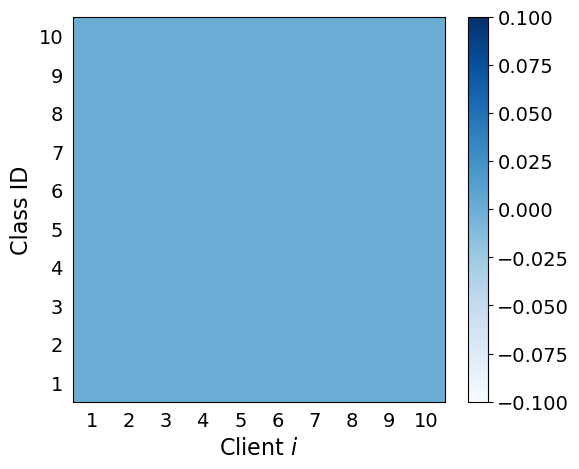

In [84]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot()

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelbottom=True  # labels along the bottom edge are off
) 

im = ax.pcolormesh(np.transpose(mat), edgecolors='k', linewidth=0, cmap=plt.get_cmap('Blues'))
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=14)

ax.set_xlabel('Client $i$', fontsize=16)
ax.set_ylabel('Class ID', fontsize=16)

yticks = range(1, len(class_labels)+1)
ax.set_yticks(range(0, len(yticks)))
ax.set_yticks([float(n)+0.5 for n in ax.get_yticks()])
ax.set_yticklabels(yticks)  

xticks = range(1, num_clients+1)
ax.set_xticks(range(0, num_clients))
ax.set_xticks([float(n)+0.5 for n in ax.get_xticks()])
ax.set_xticklabels(xticks) 

ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=14)
# plt.savefig(os.path.join('./figures/', '{}_beta_{}.pdf'.format(dataset_name, beta)), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join('./figures/', dataset_name + '_b_{}_c_{}.pdf'.format(beta, num_clients)), dpi=300, bbox_inches='tight')
plt.show()

### Adding Noise 

In [57]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [59]:
from training import get_config, ImgDataset

import torch
import torch.nn.functional as F

In [60]:
# Define dataset.
dataset_name = 'cifar_10'
# dataset_name = 'svhn'
# dataset_name = 'fashion_mnist'

data_config, train_config = get_config(dataset_name)

test_transform = data_config['test_transform']

In [61]:
# Data.
data_dir = os.path.join('datasets', dataset_name)

test_dir = os.path.join(data_dir, 'test')
test_data = ImgDataset(test_dir, transform=test_transform)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'datasets\\cifar_10\\test'

In [62]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [63]:
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [64]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def get_noisy_image(x_start, t):
    # add noise
    x_noisy = q_sample(x_start, t=t)
    return x_noisy

In [65]:
x, y = test_data[7003]
x = x.to(device)
utils.show_img_tensor(x, save_path=os.path.join('./figures/x0.png'))

NameError: name 'test_data' is not defined

In [66]:
# take time step
t = torch.tensor([299], device=device)
x_noisy = get_noisy_image(x, t)

TypeError: randn_like(): argument 'input' (position 1) must be Tensor, not list

In [67]:
utils.show_img_tensor(x_noisy, save_path=os.path.join('./figures/x{}.png'.format(t.item())))

NameError: name 'x_noisy' is not defined

In [78]:
 import torch

reals = torch.randn(10, 3, 32, 32)
    
rng = torch.quasirandom.SobolEngine(1, scramble=True)
    
# Draw uniformly distributed continuous timeteps
t = rng.draw(reals.shape[0])[:, 0]
t

tensor([0.2107, 0.6225, 0.8727, 0.4603, 0.3292, 0.9960, 0.7453, 0.0801, 0.0532,
        0.6526])

### Plottings

FileNotFoundError: [Errno 2] No such file or directory: './figures/fidtrain_epoch.pdf'

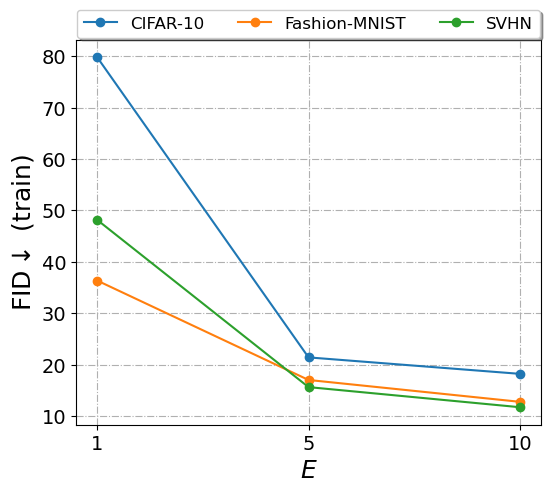

In [77]:
# IS

metric_type = 'fidtrain'                # {'is', 'fidtrain', 'fidtest'}
exp_type = 'epoch'                 # {'beta', 'client', 'epoch'}

plot_name = metric_type + '_' + exp_type

legend = ['CIFAR-10', 'Fashion-MNIST', 'SVHN']

plt.figure(figsize= (6, 5))

# if plot_name == 'is_beta':
#     y_cifar10 = [3.53, 3.69, 3.65]
#     y_fashionmnist = [4.04, 4.11, 3.94]
#     y_svhn = [3.12, 3.07, 3.14]
# elif plot_name == 'fidtrain_beta':
#     y_cifar10 = [23.14, 21.42, 25.40]
#     y_fashionmnist = [18.02, 17.03, 20.01]
#     y_svhn = [12.28, 15.64, 20.15]
# elif plot_name == 'fidtest_beta':
#     y_cifar10 = [24.42, 22.67, 26.74]
#     y_fashionmnist = [18.96, 17.91, 20.93]
#     y_svhn = [16.38, 20.39, 22.93]

if plot_name == 'is_beta':
    y_cifar10 = [3.65, 3.69, 3.53]
    y_fashionmnist = [3.94, 4.11, 4.04]
    y_svhn =  [3.14, 3.07, 3.12]
elif plot_name == 'fidtrain_beta':
    y_cifar10 = [ 25.40, 21.42, 23.14]
    y_fashionmnist = [20.01, 17.03, 18.02]
    y_svhn = [20.15, 15.64, 12.28]
elif plot_name == 'fidtest_beta':
    y_cifar10 = [26.74, 22.67, 24.42]
    y_fashionmnist = [20.93, 17.91, 18.96]
    y_svhn = [22.93, 20.39, 16.38]

if exp_type == 'beta':
    plt.xticks([0, 1, 2], ['0.1', '0.5', '5'], fontsize=14)
    plt.xlabel('$β$', fontsize=18) 
#     plt.xticks([0, 1, 2], ['5', '0.5', '0.1'], fontsize=14)
#     plt.xlabel('$β$', fontsize=18) 
    
if plot_name == 'is_client':
    y_cifar10 = [3.69, 3.02, 2.81]
    y_fashionmnist = [4.11, 3.98, 4.21]
    y_svhn = [3.07, 2.95, 2.96]
elif plot_name == 'fidtrain_client':
    y_cifar10 = [21.42, 40.09, 48.69]
    y_fashionmnist = [17.03, 19.56, 35.61]
    y_svhn = [15.64, 20.45, 23.76]
elif plot_name == 'fidtest_client':
    y_cifar10 = [22.67, 41.57, 50.23]
    y_fashionmnist = [17.91, 20.50, 36.46]
    y_svhn = [20.39, 23.48, 26.46]
    
if exp_type == 'client':
    plt.xticks([0, 1, 2], ['10', '30', '50'], fontsize=14)
    plt.xlabel('$N$', fontsize=18) 
    

    
if plot_name == 'is_epoch':
    y_cifar10 = [2.49, 3.69, 3.88 ]
    y_fashionmnist = [4.01, 4.11, 3.95]
    y_svhn = [2.33, 3.07, 3.10]
elif plot_name == 'fidtrain_epoch':
    y_cifar10 = [79.79, 21.42, 18.22]
    y_fashionmnist = [36.36, 17.03, 12.78]
    y_svhn = [48.16, 15.64, 11.73]
elif plot_name == 'fidtest_epoch':
    y_cifar10 = [81.60, 22.67, 19.51]
    y_fashionmnist = [37.31, 17.91, 13.75]
    y_svhn = [52.85, 20.39, 17.31]
    
if exp_type == 'epoch':
    plt.xticks([0, 1, 2], ['1', '5', '10'], fontsize=14)
    plt.xlabel('$E$', fontsize=18) 



if metric_type == 'is':
    plt.ylabel(r'IS$\uparrow$', fontsize=18)
elif metric_type == 'fidtrain':
    plt.ylabel(r'FID$\downarrow$ (train)', fontsize=18)
elif metric_type == 'fidtest':
    plt.ylabel(r'FID$\downarrow$ (test)', fontsize=18)

    
for y_value, name in zip([y_cifar10, y_fashionmnist, y_svhn], legend):
    plt.plot(y_value, label=name, marker='o', linestyle='-')

plt.yticks( fontsize=14)
plt.grid(True, linestyle='-.')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.savefig(os.path.join('./figures/', '{}.pdf'.format(plot_name)), dpi=300, bbox_inches='tight')
plt.show()

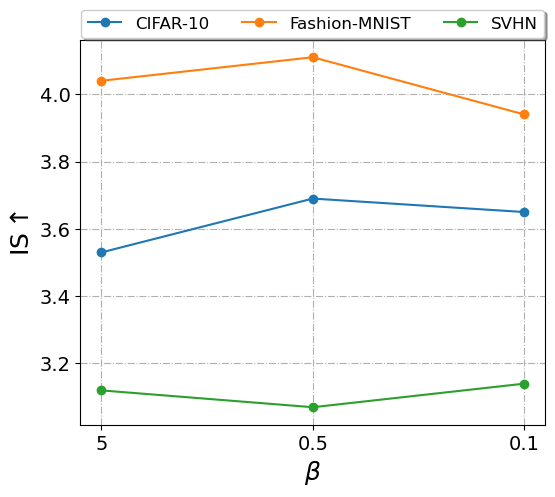

In [71]:
# IS
legend = ['CIFAR-10', 'Fashion-MNIST', 'SVHN']


plt.figure(figsize= (6, 5))

# Beta
y_cifar10 = [3.53, 3.69, 3.65]
y_fashionmnist = [4.04, 4.11, 3.94]
y_svhn = [3.12, 3.07, 3.14]
plt.xticks([0, 1, 2], ['5', '0.5', '0.1'], fontsize=14)

for y_value, name in zip([y_cifar10, y_fashionmnist, y_svhn], legend):
    plt.plot(y_value, label=name, marker='o', linestyle='-')
plt.xlabel('$β$', fontsize=18)    
plt.ylabel(r'IS$\uparrow$', fontsize=18)

plt.yticks( fontsize=14)
plt.grid(True, linestyle='-.')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3, fancybox=True, shadow=True, fontsize=12)
# plt.savefig(os.path.join('./figures/', 'cifar_10_c_10_b_0.5_le_abalation.pdf'), dpi=300, bbox_inches='tight')
plt.show()

In [72]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image


def append_color_cluster(img_path, rect_ratio_list, rect_color_list, save_path, img_width=342):
    
    img = Image.open(img_path)
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    rect_x = 0
    for i in range(len(rect_color_list)):
        rect_ratio = rect_ratio_list[i]
        rect_color = rect_color_list[i]
        rect_length = (rect_ratio / 100) * img_width
        rect = Rectangle((rect_x, -20), rect_length, 15, linewidth=0, edgecolor='r', clip_on=False, facecolor=rect_color)
        rect_x += rect_length 
        ax.add_patch(rect)
        
    plt.axis('off')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    

### Local Model Samples

In [73]:
# Image stats are generated here.
# http://mkweb.bcgsc.ca/color-summarizer/?


# img_path = './figures/cifar_c1.png'
# rect_ratio_list = [34.00, 27.88, 23.80, 14.32]
# rect_color_list = ['#777966', '#454540', '#9CA5A7', '#60778F']
# save_path = './figures/cifar_c1_color.png'

# img_path = './figures/cifar_c2.png'
# rect_ratio_list = [31.36, 27.24, 20.84, 20.56]
# rect_color_list = ['#7D7979', '#4F453E', '#947453', '#BFBDBD']
# save_path = './figures/cifar_c2_color.png'

# img_path = './figures/cifar_c5.png'
# rect_ratio_list = [32.96, 26.56, 20.36, 20.12]
# rect_color_list = ['#C8C3C2', '#8D8F97', '#5C5A58', '#958875']
# save_path = './figures/cifar_c5_color.png'

# img_path = './figures/fashion_c6.png'
# rect_ratio_list = [35.07, 26.80, 19.60, 18.53]
# rect_color_list = ['#D3D3D4', '#A3A3A5', '#676769', '#323133']
# save_path = './figures/fashion_c6_color.png'


# img_path = './figures/fashion_c6.png'
# rect_ratio_list = [31.60, 27.33, 22.67, 18.40]
# rect_color_list = ['#ADADAE', '#E2E2E2', '#2E2D2F', '#6C6C6E']
# save_path = './figures/fashion_c6_color.png'
# img_width = 172

img_path = './figures/fashion_c3.png'
rect_ratio_list = [30.40, 27.47, 23.27, 18.87]
rect_color_list = ['#B9BBB9', '#E2E3E2', '#949594', '#6E6F6D']
save_path = './figures/fashion_c3_color.png'
img_width = 172

append_color_cluster(img_path, rect_ratio_list, rect_color_list, save_path, img_width=img_width)

FileNotFoundError: [Errno 2] No such file or directory: './figures/fashion_c3.png'

In [74]:
# rect_ratio_list = [34.00, 27.88, 23.80, 14.32]
# rect_color_list = ['#777966', '#454540', '#9CA5A7', '#60778F']

# img = Image.open('./figures/cifar_c1.png')

# img_width = 342

# fig, ax = plt.subplots()
# ax.imshow(img)

# rect_x = 0
# for i in range(len(rect_color_list)):
#     rect_ratio = rect_ratio_list[i]
#     rect_color = rect_color_list[i]
#     rect_length = (rect_ratio / 100) * img_width
#     rect = Rectangle((rect_x, -30), rect_length, 20, linewidth=0, edgecolor='r', clip_on=False, facecolor=rect_color)
#     rect_x += rect_length 
#     ax.add_patch(rect)

# plt.axis('off')
# plt.show()

In [75]:
# import matplotlib.pyplot as plt
# # import matplotlib.pyplot as pyplot
# from matplotlib.patches import Rectangle
# from PIL import Image

# im = Image.open('./figures/cifar_c1.png')

# # Create figure and axes
# fig, ax = plt.subplots()

# # Display the image
# ax.imshow(im)

# # Create a Rectangle patch
# rect_1 = Rectangle((0, -30), (34.00 / 100) * 320, 20, linewidth=0, edgecolor='r', clip_on=False, facecolor='#777966')
# rect_2 = Rectangle(((34.00 / 100) * 320, -30), (27.88 / 100) * 320, 20, linewidth=0, edgecolor='r', clip_on=False, facecolor='#454540')
# rect_3 = Rectangle(((27.88 / 100) * 320, -30), (23.80 / 100) * 320, 20, linewidth=0, edgecolor='r', clip_on=False, facecolor='#9CA5A7')
# rect_4 = Rectangle(((23.80 / 100) * 320, -30), (14.32 / 100) * 320, 20, linewidth=0, edgecolor='r', clip_on=False, facecolor='#60778F')

# # ax.add_patch(plt.Rectangle((0,-60),60, 10,facecolor='silver', clip_on=False, linewidth = 0))


# # Add the patch to the Axes
# ax.add_patch(rect_1)
# ax.add_patch(rect_2)
# ax.add_patch(rect_3)
# ax.add_patch(rect_4)

# plt.show()

In [76]:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# from PIL import Image


# rect_ratio_list = [34.00, 27.88, 23.80, 14.32]
# rect_color_list = ['#777966', '#454540', '#9CA5A7', '#60778F']

# img = Image.open('./figures/cifar_c1.png')
# img_width = 342

# fig, ax = plt.subplots()
# ax.imshow(img)

# rect_x = 0
# for i in range(len(rect_color_list)):
#     rect_ratio = rect_ratio_list[i]
#     rect_color = rect_color_list[i]
#     rect_length = (rect_ratio / 100) * img_width
#     rect = Rectangle((rect_x, -30), rect_length, 20, linewidth=0, edgecolor='r', clip_on=False, facecolor=rect_color)
#     rect_x += rect_length 
#     ax.add_patch(rect)

# plt.axis('off')
# plt.show()